<a href="https://colab.research.google.com/github/jchen8000/GenerativeAI/blob/main/4_Pre-Training_Fine-Tuning/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning with TweetSum Dataset

This code is tested and working on Google Colab GPU T4 with below packages

*   torch==2.1.0+cu121
*   datasets==2.18.0
*   sentencepiece==0.1.99
*   transformers==4.38.2
*   accelerate==0.27.2
*   rouge_score==0.1.2


In [1]:
!pip install datasets --quiet
!pip install sentencepiece --quiet
!pip install transformers --quiet
!pip install accelerate --quiet
!pip install rouge_score --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset, load_metric
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer
from rouge_score import rouge_scorer

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load FLAN-T5 Small model

In [6]:
def load_model(model_name):
    # Initialize the tokenizer and model from the pretrained version on Hugging Face
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    return tokenizer, model

tokenizer, model = load_model('google/flan-t5-small')
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Parameters of the model: 76,961,152


## Load TweetSum Dataset

https://github.com/sarahaman/CIS6930_TweetSum_Summarization

Make sure the three files in the datasets folder:

*  tweetsum_train.csv
*  tweetsum_valid.csv
*  tweetsum_test.csv

In [8]:
tweetsum = load_dataset('csv', data_files={'train': 'datasets/tweetsum_train.csv',
                                          'validation': 'datasets/tweetsum_valid.csv',
                                          'test': 'datasets/tweetsum_test.csv'})
print(tweetsum)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 108
    })
    test: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 110
    })
})


## Tokenize the dataset

In [9]:
def tokenize_function(example):
  prompt = ["Summarize: " + s for s in example['inputs']]
  example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
  example['labels'] = tokenizer(example['summaries'], padding="max_length", truncation=True, return_tensors="pt").input_ids
  return example


Take a subset of the original dataset, in order to run the fine-tuning on the limited resources (single GPU, etc.)

In [10]:
tokenized_datasets = tweetsum.map(tokenize_function, batched=True)
# tokenized_datasets = tokenized_datasets.remove_columns(['inputs', 'summaries'])
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 4 == 0, with_indices=True )
print(tokenized_datasets)

Map:   0%|          | 0/869 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Filter:   0%|          | 0/869 [00:00<?, ? examples/s]

Filter:   0%|          | 0/108 [00:00<?, ? examples/s]

Filter:   0%|          | 0/110 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 218
    })
    validation: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 27
    })
    test: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 28
    })
})


## Preliminary evaluation by human assessment

In [11]:
def generate_output(tokenizer, model, input_text, max_length=200):
    # Tokenize the input text and generate the model's output
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids, max_length=max_length)

    # Decode the generated tokens to a string
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


Generate 5 random indices:

In [ ]:
# indices = torch.randint(0, tokenized_datasets['test'].num_rows, (5,))
# indices = indices.tolist()
# indices

Produce the output on the 5 data sample:

In [12]:
for i in [14, 7, 26, 0, 19]:
    prompt = "Summarize: " + tokenized_datasets['test'][i]['inputs']
    output = generate_output(tokenizer, model, prompt)
    print("Prompt:", prompt)
    print("Target:", tokenized_datasets['test'][i]['summaries'])
    print("Predict:", output)
    print()

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


Prompt: Summarize: AmericanAir I need to change my last name to my married name on my AAdvantage acct. Help. <BR> Our specialists are available to help. Give them a call at 8008828880. <BR> AmericanAir not helpful. <BR> For security purposes, all name changes have to be handled through AAdvantage Customer Service directly. Theyll gladly assist you, Janel. <BR> AmericanAir FYI The only thing customer service did was email me a prompt to provide proof of my name change. allowed me to perform this step via their website. United 1, AA 0. <BR> Please submit the docs that our Customer Service team is requesting then. We appreciate your cooperation. <BR> AmericanAir I did. <BR> Great! Please continue working with them and theyll let you know what the next steps are. <BR>
Target: The customer is asking to change their name. The agent asked the customer to call them at 800-882-8880 for further assistance.
Predict: AmericanAir

Prompt: Summarize: hulusupport Current version of your Hulu app for 

## Fine-tuning

In [ ]:
batch_size = 8
epochs = 80

training_args = TrainingArguments(
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    logging_steps=1,
    # bf16=True,
    # fp16=True,
    num_train_epochs=epochs,
    output_dir = 'outputs'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,28.916100,30.461964
2,20.689100,17.516727
3,7.724800,5.802479
4,5.141100,4.579702
5,4.435400,4.098464
6,4.087200,3.687513
7,3.606500,3.263892
8,3.341100,2.926857
9,3.029100,2.631284
10,2.757100,2.352322


TrainOutput(global_step=2240, training_loss=1.7196713627449103, metrics={'train_runtime': 1792.6613, 'train_samples_per_second': 9.729, 'train_steps_per_second': 1.25, 'total_flos': 3241930402037760.0, 'train_loss': 1.7196713627449103, 'epoch': 80.0})

In [ ]:
pred = trainer.predict(tokenized_datasets["test"])
pred.metrics

{'test_loss': 0.1901451200246811,
 'test_runtime': 2.3994,
 'test_samples_per_second': 11.67,
 'test_steps_per_second': 1.667}

In [ ]:
trainer.save_model("outputs/flan-t5-small_finetune")

## Visualize the fine-tuning

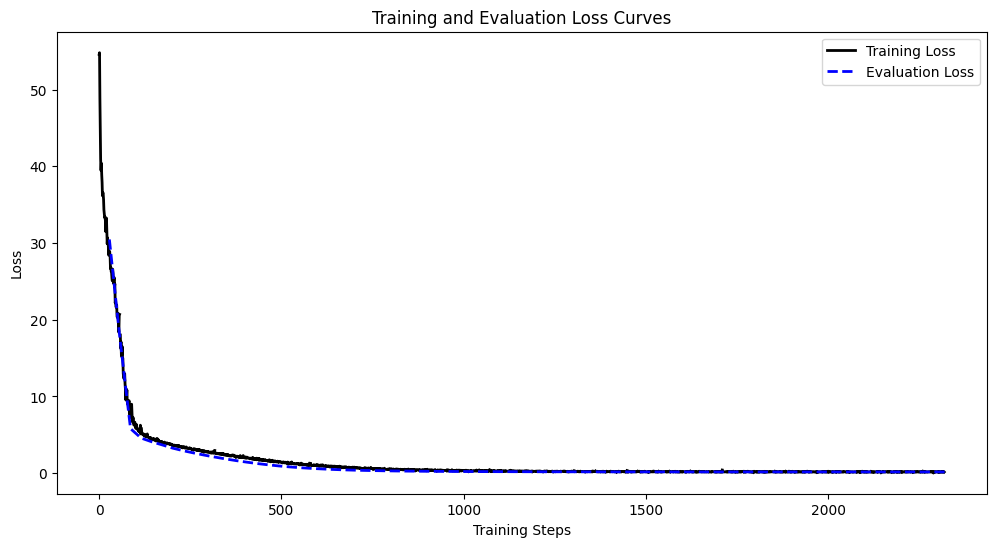

In [ ]:
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

if 'loss' in df.columns and 'eval_loss' in df.columns:
    df_filtered = df.dropna(subset=['loss', 'eval_loss'], how='all')
    df_filtered.reset_index(drop=True, inplace=True)
    # df_filtered['eval_loss'] = df_filtered['eval_loss'].ffill()

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['loss'], lw=2, c='k', label='Training Loss')
    plt.plot(df_filtered['eval_loss'].dropna(), lw=2, c='b', ls='--', label='Evaluation Loss')

    plt.title('Training and Evaluation Loss Curves')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("outputs/fine-tuning.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
    plt.show()

## Evaluation on the fine-tuned model

Load the saved fine-tuned model:

In [23]:
ft_model = T5ForConditionalGeneration.from_pretrained("outputs/flan-t5-small_finetune")

Human assessment on selected data samples:

In [24]:
for i in [14, 7, 26, 0, 19]:
    prompt = "Summarize: " + tokenized_datasets['test']['inputs'][i]
    output = generate_output(tokenizer, ft_model, prompt)
    print("Prompt:", prompt)
    print("Target:", tokenized_datasets['test']['summaries'][i])
    print("Predict:", output)
    print()

Prompt: Summarize: AmericanAir I need to change my last name to my married name on my AAdvantage acct. Help. <BR> Our specialists are available to help. Give them a call at 8008828880. <BR> AmericanAir not helpful. <BR> For security purposes, all name changes have to be handled through AAdvantage Customer Service directly. Theyll gladly assist you, Janel. <BR> AmericanAir FYI The only thing customer service did was email me a prompt to provide proof of my name change. allowed me to perform this step via their website. United 1, AA 0. <BR> Please submit the docs that our Customer Service team is requesting then. We appreciate your cooperation. <BR> AmericanAir I did. <BR> Great! Please continue working with them and theyll let you know what the next steps are. <BR>
Target: The customer is asking to change their name. The agent asked the customer to call them at 800-882-8880 for further assistance.
Predict: Customer is requesting to change their last name to their married name on their A

ROUGE Scores:

In [4]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
generated = "Customer is requesting to change her name on their AAdvantage acct."
reference = "The customer is asking to change her name, the agent asks her to call customer service."
scores = scorer.score(reference, generated)
print(scores['rouge1'])

{'rouge1': Score(precision=0.5454545454545454, recall=0.375, fmeasure=0.4444444444444444), 'rouge2': Score(precision=0.4, recall=0.26666666666666666, fmeasure=0.32), 'rougeL': Score(precision=0.5454545454545454, recall=0.375, fmeasure=0.4444444444444444)}


In [27]:
for item in tokenized_datasets['test']:
    prompt = "Summarize: " + item['inputs']
    output = generate_output(tokenizer, ft_model, prompt)
    scores = scorer.score(item['summaries'], output)
    print("Target:", item['summaries'])
    print("Predict:", output)
    print(scores)
    print()

Target: Customer is complaining that the watchlist is not updated with new episodes from past two days. Agent informed that the team is working hard to investigate to show new episodes on page.
Predict: The watchlist is not updating with new episodes past couple days.
{'rouge1': Score(precision=0.9090909090909091, recall=0.3125, fmeasure=0.4651162790697674), 'rouge2': Score(precision=0.7, recall=0.22580645161290322, fmeasure=0.3414634146341463), 'rougeL': Score(precision=0.9090909090909091, recall=0.3125, fmeasure=0.4651162790697674)}

Target: The customer says that he is stuck at Staines waiting for a Reading train, and asks why no information has been passed on to the passengers at the platform. The agent says that due to electricity supply problems trains are not running to Reading and adds that they have just been informed by their engineers that the line is open again and trains can now run between Workingham and Reading.
Predict: The train is not running to Reading.
{'rouge1': Sc